# Importing relevant libraries

In [226]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
sb.set()

# Importing relevant data 

In [227]:
# each row shows per round results
demo_df = pd.read_csv("dataset/esea_meta_demos.part1.csv")

# shows each encounter when damage is taken
dmg_df = pd.read_csv("dataset/esea_master_dmg_demos.part1.csv")

# shows each kill (regardless of current hp)
kill_df = pd.read_csv("dataset/esea_master_kills_demos.part1.csv")

# each map has xy value corresponding to coordinates in dmg_df
# convert df to dict for easy access
map_df = pd.read_csv("dataset/map_data.csv").rename(columns={'Unnamed: 0':'map_name'})
map_dict = map_df.set_index("map_name").transpose().to_dict()

# Data Cleaning

In [228]:
display(demo_df.head())
display(dmg_df.head())
display(kill_df.head())

,file,map,round,start_seconds,end_seconds,winner_team,winner_side,round_type,ct_eq_val,t_eq_val
0,esea_match_13770997.dem,de_overpass,1,94.30782,160.9591,Hentai Hooligans,Terrorist,PISTOL_ROUND,4300,4250
1,esea_match_13770997.dem,de_overpass,2,160.95910,279.3998,Hentai Hooligans,Terrorist,ECO,6300,19400
2,esea_match_13770997.dem,de_overpass,3,279.39980,341.0084,Hentai Hooligans,Terrorist,SEMI_ECO,7650,19250
3,esea_match_13770997.dem,de_overpass,4,341.00840,435.4259,Hentai Hooligans,Terrorist,NORMAL,24900,23400
4,esea_match_13770997.dem,de_overpass,5,435.42590,484.2398,Animal Style,CounterTerrorist,ECO,5400,20550


,file,round,tick,seconds,att_team,vic_team,att_side,vic_side,hp_dmg,arm_dmg,...,wp,wp_type,att_id,att_rank,vic_id,vic_rank,att_pos_x,att_pos_y,vic_pos_x,vic_pos_y
0,esea_match_13770997.dem,1,14372,111.8476,World,Animal Style,None,CounterTerrorist,1,0,...,Unknown,Unkown,0,0,76561198055054795,0,0.0000,0.00000,0.0000,0.000000
1,esea_match_13770997.dem,1,15972,124.3761,Animal Style,Hentai Hooligans,CounterTerrorist,Terrorist,18,9,...,USP,Pistol,76561198048742997,0,76561198082200410,0,-1499.6900,63.33829,-669.5558,-79.769570
2,esea_match_13770997.dem,1,16058,125.0495,Animal Style,Hentai Hooligans,CounterTerrorist,Terrorist,100,0,...,USP,Pistol,76561198055054795,0,76561197961009213,0,-1066.8740,3.44563,-614.1868,-91.707770
3,esea_match_13770997.dem,1,16066,125.1121,Hentai Hooligans,Animal Style,Terrorist,CounterTerrorist,12,7,...,Glock,Pistol,76561198082200410,0,76561198055054795,0,-747.3146,-49.32681,-1065.5560,9.381622
4,esea_match_13770997.dem,1,16108,125.4410,Animal Style,Hentai Hooligans,CounterTerrorist,Terrorist,15,7,...,USP,Pistol,76561198048742997,0,76561198082200410,0,-1501.8610,49.19798,-748.4188,-53.469220


,file,round,tick,seconds,att_team,vic_team,att_side,vic_side,wp,wp_type,ct_alive,t_alive,is_bomb_planted
0,esea_match_13770997.dem,1,16058,30.74165,Animal Style,Hentai Hooligans,CounterTerrorist,Terrorist,USP,Pistol,5,4,False
1,esea_match_13770997.dem,1,16210,31.93185,Hentai Hooligans,Animal Style,Terrorist,CounterTerrorist,Glock,Pistol,4,4,False
2,esea_match_13770997.dem,1,16510,34.28094,Hentai Hooligans,Animal Style,Terrorist,CounterTerrorist,Glock,Pistol,3,4,False
3,esea_match_13770997.dem,1,17104,38.93212,Animal Style,Hentai Hooligans,CounterTerrorist,Terrorist,USP,Pistol,3,3,False
4,esea_match_13770997.dem,1,17338,40.76441,Hentai Hooligans,Animal Style,Terrorist,CounterTerrorist,Glock,Pistol,2,3,False


Add <b>round_duration</b> by subtracting end-start seconds.

In [229]:
demo_updated_df = demo_df.assign(round_duration=lambda x: x.end_seconds - x.start_seconds)
demo_updated_df.head()

,file,map,round,start_seconds,end_seconds,winner_team,winner_side,round_type,ct_eq_val,t_eq_val,round_duration
0,esea_match_13770997.dem,de_overpass,1,94.30782,160.9591,Hentai Hooligans,Terrorist,PISTOL_ROUND,4300,4250,66.65128
1,esea_match_13770997.dem,de_overpass,2,160.95910,279.3998,Hentai Hooligans,Terrorist,ECO,6300,19400,118.44070
2,esea_match_13770997.dem,de_overpass,3,279.39980,341.0084,Hentai Hooligans,Terrorist,SEMI_ECO,7650,19250,61.60860
3,esea_match_13770997.dem,de_overpass,4,341.00840,435.4259,Hentai Hooligans,Terrorist,NORMAL,24900,23400,94.41750
4,esea_match_13770997.dem,de_overpass,5,435.42590,484.2398,Animal Style,CounterTerrorist,ECO,5400,20550,48.81390


Add <b>loser_side, t_win and ct_win </b> for easier manipulation of data onwards.

In [230]:
demo_updated_df['loser_side'] = np.where(demo_updated_df['winner_side']== 'Terrorist', 'CounterTerrorist', 'Terrorist')
demo_updated_df['t_win'] = np.where(demo_updated_df['winner_side']== 'Terrorist', True, False)
demo_updated_df['ct_win'] = np.where(demo_updated_df['winner_side']== 'CounterTerrorist', True, False)
demo_updated_df.head()

,file,map,round,start_seconds,end_seconds,winner_team,winner_side,round_type,ct_eq_val,t_eq_val,round_duration,loser_side,t_win,ct_win
0,esea_match_13770997.dem,de_overpass,1,94.30782,160.9591,Hentai Hooligans,Terrorist,PISTOL_ROUND,4300,4250,66.65128,CounterTerrorist,True,False
1,esea_match_13770997.dem,de_overpass,2,160.95910,279.3998,Hentai Hooligans,Terrorist,ECO,6300,19400,118.44070,CounterTerrorist,True,False
2,esea_match_13770997.dem,de_overpass,3,279.39980,341.0084,Hentai Hooligans,Terrorist,SEMI_ECO,7650,19250,61.60860,CounterTerrorist,True,False
3,esea_match_13770997.dem,de_overpass,4,341.00840,435.4259,Hentai Hooligans,Terrorist,NORMAL,24900,23400,94.41750,CounterTerrorist,True,False
4,esea_match_13770997.dem,de_overpass,5,435.42590,484.2398,Animal Style,CounterTerrorist,ECO,5400,20550,48.81390,Terrorist,False,True


Remove relevant <b>null</b> values.

In [231]:
demo_updated_df.isnull().sum()

file               0
map                0
round              0
start_seconds     20
end_seconds       20
winner_team        1
winner_side        0
round_type         0
ct_eq_val          0
t_eq_val           0
round_duration    20
loser_side         0
t_win              0
ct_win             0
dtype: int64

In [232]:
demo_updated_df = demo_updated_df[~demo_updated_df['start_seconds'].isnull()]
demo_updated_df.isnull().sum()

file              0
map               0
round             0
start_seconds     0
end_seconds       0
winner_team       1
winner_side       0
round_type        0
ct_eq_val         0
t_eq_val          0
round_duration    0
loser_side        0
t_win             0
ct_win            0
dtype: int64

Some matches has <b>missing rounds</b>, so we <b>remove them</b>.

In [233]:
demo_updated_df[demo_updated_df['file']=='esea_match_13770997.dem'].tail() # 25 rounds, but only 23 rows

,file,map,round,start_seconds,end_seconds,winner_team,winner_side,round_type,ct_eq_val,t_eq_val,round_duration,loser_side,t_win,ct_win
19,esea_match_13770997.dem,de_overpass,21,1786.007,1844.938,Hentai Hooligans,CounterTerrorist,NORMAL,31450,26300,58.931,Terrorist,False,True
20,esea_match_13770997.dem,de_overpass,22,1844.938,1999.946,Animal Style,Terrorist,NORMAL,30200,22050,155.008,CounterTerrorist,True,False
21,esea_match_13770997.dem,de_overpass,23,1999.946,2100.158,Hentai Hooligans,CounterTerrorist,NORMAL,18200,29300,100.212,Terrorist,False,True
22,esea_match_13770997.dem,de_overpass,24,2100.158,2157.930,Hentai Hooligans,CounterTerrorist,FORCE_BUY,29100,16150,57.772,Terrorist,False,True
23,esea_match_13770997.dem,de_overpass,25,2157.930,2207.949,Hentai Hooligans,CounterTerrorist,SEMI_ECO,27800,10900,50.019,Terrorist,False,True


In [234]:
file_unique = demo_updated_df['file'].unique() 

incomplete_matches = []

# put every match in a list that does not have a complete set of rounds by comparing difference in index and round of min and max
for file_name in file_unique:
    max_id = demo_updated_df.file.values.searchsorted(file_name, side='right')
    min_id = demo_updated_df.file.values.searchsorted(file_name, side='left')
    expected_total_rounds = max_id-min_id
    actual_rounds = demo_updated_df.iloc[max_id-1]['round']

    if (actual_rounds!=expected_total_rounds):
        incomplete_matches.append(file_name)

# remove incomplete matches
demo_clean_df = demo_updated_df[~demo_updated_df['file'].isin(incomplete_matches)]
dmg_clean_df = dmg_df[~dmg_df['file'].isin(incomplete_matches)]
kill_clean_df = kill_df[~kill_df['file'].isin(incomplete_matches)]

In [235]:
display(demo_clean_df.head())
display(dmg_clean_df.head())
display(kill_clean_df.head())

,file,map,round,start_seconds,end_seconds,winner_team,winner_side,round_type,ct_eq_val,t_eq_val,round_duration,loser_side,t_win,ct_win
24,esea_match_13779704.dem,de_cache,1,131.2592,188.1189,Team 1,CounterTerrorist,PISTOL_ROUND,4550,3850,56.8597,Terrorist,False,True
25,esea_match_13779704.dem,de_cache,2,188.1189,274.7697,Team 2,Terrorist,ECO,18450,5300,86.6508,CounterTerrorist,True,False
26,esea_match_13779704.dem,de_cache,3,274.7697,348.5590,Team 2,Terrorist,SEMI_ECO,9550,22900,73.7893,CounterTerrorist,True,False
27,esea_match_13779704.dem,de_cache,4,348.5590,419.6258,Team 2,Terrorist,ECO,1600,19650,71.0668,CounterTerrorist,True,False
28,esea_match_13779704.dem,de_cache,5,419.6258,487.9857,Team 1,CounterTerrorist,NORMAL,23350,21750,68.3599,Terrorist,False,True


,file,round,tick,seconds,att_team,vic_team,att_side,vic_side,hp_dmg,arm_dmg,...,wp,wp_type,att_id,att_rank,vic_id,vic_rank,att_pos_x,att_pos_y,vic_pos_x,vic_pos_y
759,esea_match_13779704.dem,1,20759,161.8639,Team 1,Team 2,CounterTerrorist,Terrorist,15,7,...,USP,Pistol,76561198078736000,0,76561198371993258,0,-170.91130,2002.935,511.5505,1678.621
760,esea_match_13779704.dem,1,20961,163.4442,Team 1,Team 2,CounterTerrorist,Terrorist,31,0,...,USP,Pistol,76561198078736000,0,76561197962264927,0,-256.35050,1958.900,357.7615,1831.760
761,esea_match_13779704.dem,1,21001,163.7572,Team 2,Team 1,Terrorist,CounterTerrorist,11,6,...,Glock,Pistol,76561197962264927,0,76561198078736000,0,348.90870,1830.443,-267.8188,1902.607
762,esea_match_13779704.dem,1,21093,164.4769,Team 1,Team 2,CounterTerrorist,Terrorist,85,0,...,USP,Pistol,76561198242564394,0,76561198371993258,0,55.05295,1413.524,187.1718,1951.511
763,esea_match_13779704.dem,1,21179,165.1497,Team 1,Team 2,CounterTerrorist,Terrorist,32,0,...,USP,Pistol,76561198242564394,0,76561197962264927,0,68.18559,1411.809,275.8283,1780.951


,file,round,tick,seconds,att_team,vic_team,att_side,vic_side,wp,wp_type,ct_alive,t_alive,is_bomb_planted
184,esea_match_13779704.dem,1,21093,33.21770,Team 1,Team 2,CounterTerrorist,Terrorist,USP,Pistol,5,4,False
185,esea_match_13779704.dem,1,21251,34.45378,Team 1,Team 2,CounterTerrorist,Terrorist,USP,Pistol,5,3,False
186,esea_match_13779704.dem,1,21341,35.15788,Team 2,Team 1,Terrorist,CounterTerrorist,Glock,Pistol,4,3,False
187,esea_match_13779704.dem,1,21883,39.39810,Team 1,Team 2,CounterTerrorist,Terrorist,USP,Pistol,4,2,False
188,esea_match_13779704.dem,1,23091,48.84865,Team 1,Team 2,CounterTerrorist,Terrorist,USP,Pistol,4,1,False


<b>Merge all dataframes</b> into one big dataframe (to add their columns together).

In [236]:
# add the unique columns of dmg_clean_df to kill_clean_df
kill_confirm_df = dmg_clean_df.merge(kill_clean_df, how='inner', on=['file','tick'], suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)').drop(columns=['att_rank','vic_rank'])
kill_confirm_df.head()

,file,round,tick,seconds,att_team,vic_team,att_side,vic_side,hp_dmg,arm_dmg,...,wp,wp_type,att_id,vic_id,att_pos_x,att_pos_y,vic_pos_x,vic_pos_y,ct_alive,t_alive
0,esea_match_13779704.dem,1,21093,164.4769,Team 1,Team 2,CounterTerrorist,Terrorist,85,0,...,USP,Pistol,76561198242564394,76561198371993258,55.05295,1413.524,187.1718,1951.511,5,4
1,esea_match_13779704.dem,1,21251,165.7130,Team 1,Team 2,CounterTerrorist,Terrorist,37,0,...,USP,Pistol,76561198242564394,76561197962264927,60.15099,1415.707,242.1282,1770.468,5,3
2,esea_match_13779704.dem,1,21341,166.4171,Team 2,Team 1,Terrorist,CounterTerrorist,100,0,...,Glock,Pistol,76561198168699127,76561198242564394,184.84450,1324.460,124.2944,1342.035,4,3
3,esea_match_13779704.dem,1,21883,170.6573,Team 1,Team 2,CounterTerrorist,Terrorist,100,0,...,USP,Pistol,76561198078736000,76561198121398598,-264.34310,2235.892,600.5919,1621.023,4,2
4,esea_match_13779704.dem,1,23091,180.1078,Team 1,Team 2,CounterTerrorist,Terrorist,67,0,...,USP,Pistol,76561198235034756,76561198168699127,-929.91270,1230.132,379.8438,1429.177,4,1


In [237]:
# add unique columns of kill_confirm_df to demo_clean_df
cleaned_df = kill_confirm_df.merge(demo_clean_df, how='inner', on=['file','round'], suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
cleaned_df.head()

,file,round,tick,seconds,att_team,vic_team,att_side,vic_side,hp_dmg,arm_dmg,...,end_seconds,winner_team,winner_side,round_type,ct_eq_val,t_eq_val,round_duration,loser_side,t_win,ct_win
0,esea_match_13779704.dem,1,21093,164.4769,Team 1,Team 2,CounterTerrorist,Terrorist,85,0,...,188.1189,Team 1,CounterTerrorist,PISTOL_ROUND,4550,3850,56.8597,Terrorist,False,True
1,esea_match_13779704.dem,1,21251,165.7130,Team 1,Team 2,CounterTerrorist,Terrorist,37,0,...,188.1189,Team 1,CounterTerrorist,PISTOL_ROUND,4550,3850,56.8597,Terrorist,False,True
2,esea_match_13779704.dem,1,21341,166.4171,Team 2,Team 1,Terrorist,CounterTerrorist,100,0,...,188.1189,Team 1,CounterTerrorist,PISTOL_ROUND,4550,3850,56.8597,Terrorist,False,True
3,esea_match_13779704.dem,1,21883,170.6573,Team 1,Team 2,CounterTerrorist,Terrorist,100,0,...,188.1189,Team 1,CounterTerrorist,PISTOL_ROUND,4550,3850,56.8597,Terrorist,False,True
4,esea_match_13779704.dem,1,23091,180.1078,Team 1,Team 2,CounterTerrorist,Terrorist,67,0,...,188.1189,Team 1,CounterTerrorist,PISTOL_ROUND,4550,3850,56.8597,Terrorist,False,True


In [238]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309137 entries, 0 to 1309136
Data columns (total 35 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   file             1309137 non-null  object 
 1   round            1309137 non-null  int64  
 2   tick             1309137 non-null  int64  
 3   seconds          1309137 non-null  float64
 4   att_team         1309137 non-null  object 
 5   vic_team         1309137 non-null  object 
 6   att_side         1309137 non-null  object 
 7   vic_side         1309137 non-null  object 
 8   hp_dmg           1309137 non-null  int64  
 9   arm_dmg          1309137 non-null  int64  
 10  is_bomb_planted  1309137 non-null  bool   
 11  bomb_site        221532 non-null   object 
 12  hitbox           1309137 non-null  object 
 13  wp               1309137 non-null  object 
 14  wp_type          1309137 non-null  object 
 15  att_id           1309137 non-null  int64  
 16  vic_id           1

In [239]:
cleaned_df.isnull().sum()

file                     0
round                    0
tick                     0
seconds                  0
att_team                 0
vic_team                 0
att_side                 0
vic_side                 0
hp_dmg                   0
arm_dmg                  0
is_bomb_planted          0
bomb_site          1087605
hitbox                   0
wp                       0
wp_type                  0
att_id                   0
vic_id                   0
att_pos_x                0
att_pos_y                0
vic_pos_x                0
vic_pos_y                0
ct_alive                 0
t_alive                  0
map                      0
start_seconds            0
end_seconds              0
winner_team              0
winner_side              0
round_type               0
ct_eq_val                0
t_eq_val                 0
round_duration           0
loser_side               0
t_win                    0
ct_win                   0
dtype: int64

<b>Export clean dataset</b> for use in other notebooks.

In [240]:
#cleaned_df.to_csv("dataset/clean.csv")

Drop rows and columns to make a <b>new dataframe</b> that shows the <b>round-end stats</b>.

In [241]:
round_end_stats_df = cleaned_df.drop_duplicates(keep='last',subset=['file','round']).drop(columns=['hitbox','wp','wp_type','att_pos_x','att_pos_y','vic_pos_x','vic_pos_y','arm_dmg','hp_dmg','start_seconds','end_seconds','vic_id','att_id','att_team','vic_team','att_side','vic_side','tick','seconds'])
round_end_stats_df.head()

,file,round,is_bomb_planted,bomb_site,ct_alive,t_alive,map,winner_team,winner_side,round_type,ct_eq_val,t_eq_val,round_duration,loser_side,t_win,ct_win
5,esea_match_13779704.dem,1,False,NaN,4,0,de_cache,Team 1,CounterTerrorist,PISTOL_ROUND,4550,3850,56.8597,Terrorist,False,True
14,esea_match_13779704.dem,2,False,NaN,0,1,de_cache,Team 2,Terrorist,ECO,18450,5300,86.6508,CounterTerrorist,True,False
22,esea_match_13779704.dem,3,True,B,0,3,de_cache,Team 2,Terrorist,SEMI_ECO,9550,22900,73.7893,CounterTerrorist,True,False
28,esea_match_13779704.dem,4,True,A,0,4,de_cache,Team 2,Terrorist,ECO,1600,19650,71.0668,CounterTerrorist,True,False
35,esea_match_13779704.dem,5,False,NaN,3,0,de_cache,Team 1,CounterTerrorist,NORMAL,23350,21750,68.3599,Terrorist,False,True


In [242]:
round_end_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 176768 entries, 5 to 1309136
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   file             176768 non-null  object 
 1   round            176768 non-null  int64  
 2   is_bomb_planted  176768 non-null  bool   
 3   bomb_site        82803 non-null   object 
 4   ct_alive         176768 non-null  int64  
 5   t_alive          176768 non-null  int64  
 6   map              176768 non-null  object 
 7   winner_team      176768 non-null  object 
 8   winner_side      176768 non-null  object 
 9   round_type       176768 non-null  object 
 10  ct_eq_val        176768 non-null  int64  
 11  t_eq_val         176768 non-null  int64  
 12  round_duration   176768 non-null  float64
 13  loser_side       176768 non-null  object 
 14  t_win            176768 non-null  bool   
 15  ct_win           176768 non-null  bool   
dtypes: bool(3), float64(1), int64(5), obj

In [243]:
round_end_stats_df.isnull().sum()

file                   0
round                  0
is_bomb_planted        0
bomb_site          93965
ct_alive               0
t_alive                0
map                    0
winner_team            0
winner_side            0
round_type             0
ct_eq_val              0
t_eq_val               0
round_duration         0
loser_side             0
t_win                  0
ct_win                 0
dtype: int64

In [244]:
round_end_stats_df['bomb_site'].fillna('Not Planted', inplace = True)
round_end_stats_df

,file,round,is_bomb_planted,bomb_site,ct_alive,t_alive,map,winner_team,winner_side,round_type,ct_eq_val,t_eq_val,round_duration,loser_side,t_win,ct_win
5,esea_match_13779704.dem,1,False,Not Planted,4,0,de_cache,Team 1,CounterTerrorist,PISTOL_ROUND,4550,3850,56.8597,Terrorist,False,True
14,esea_match_13779704.dem,2,False,Not Planted,0,1,de_cache,Team 2,Terrorist,ECO,18450,5300,86.6508,CounterTerrorist,True,False
22,esea_match_13779704.dem,3,True,B,0,3,de_cache,Team 2,Terrorist,SEMI_ECO,9550,22900,73.7893,CounterTerrorist,True,False
28,esea_match_13779704.dem,4,True,A,0,4,de_cache,Team 2,Terrorist,ECO,1600,19650,71.0668,CounterTerrorist,True,False
35,esea_match_13779704.dem,5,False,Not Planted,3,0,de_cache,Team 1,CounterTerrorist,NORMAL,23350,21750,68.3599,Terrorist,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1309095,esea_match_13793043.dem,14,True,A,0,3,de_cache,Team 2,Terrorist,NORMAL,28400,25800,66.0850,CounterTerrorist,True,False
1309101,esea_match_13793043.dem,15,False,Not Planted,4,0,de_cache,Team 1,CounterTerrorist,FORCE_BUY,13150,25550,56.8700,Terrorist,False,True
1309110,esea_match_13793043.dem,16,False,Not Planted,2,0,de_cache,Team 2,CounterTerrorist,PISTOL_ROUND,4200,4250,67.3360,Terrorist,False,True
1309117,esea_match_13793043.dem,17,False,Not Planted,4,0,de_cache,Team 2,CounterTerrorist,SEMI_ECO,18300,8200,53.9760,Terrorist,False,True


<b>Export round-end stats dataset</b> for use in other notebooks.

In [245]:
#round_end_stats_df.to_csv("dataset/round_end_stats.csv")

# EDA

Separate the dataset based on their map locations and put each result in a dictionary.

In [246]:
#seperate df based on maps
df_cleaned_sep_df = {}
df_round_end_sep_df = {}

for map_name in map_dict.keys():
    '''
    df = cleaned_df[cleaned_df['map']==map_name] 
    df_clean = df[['map','vic_pos_x','vic_pos_y','att_pos_x','att_pos_y']] # select values for mapping
    df_sep_map[map_name] = df_clean
    '''
    df_cleaned_sep_df[map_name] = cleaned_df[cleaned_df['map']==map_name] 
    df_round_end_sep_df[map_name] = round_end_stats_df[round_end_stats_df['map']==map_name] 


In [247]:
display(df_cleaned_sep_df['de_train'].head())
display(df_round_end_sep_df['de_train'].head())

,file,round,tick,seconds,att_team,vic_team,att_side,vic_side,hp_dmg,arm_dmg,...,end_seconds,winner_team,winner_side,round_type,ct_eq_val,t_eq_val,round_duration,loser_side,t_win,ct_win
2320,esea_match_13779798.dem,1,20446,159.3297,Team 2,Team 1,Terrorist,CounterTerrorist,100,0,...,196.2378,Team 2,Terrorist,PISTOL_ROUND,3250,3650,64.6245,CounterTerrorist,True,False
2321,esea_match_13779798.dem,1,21388,166.7050,Team 2,Team 1,Terrorist,CounterTerrorist,64,0,...,196.2378,Team 2,Terrorist,PISTOL_ROUND,3250,3650,64.6245,CounterTerrorist,True,False
2322,esea_match_13779798.dem,1,21636,168.6467,Team 2,Team 1,Terrorist,CounterTerrorist,100,0,...,196.2378,Team 2,Terrorist,PISTOL_ROUND,3250,3650,64.6245,CounterTerrorist,True,False
2323,esea_match_13779798.dem,1,22352,174.2526,Team 1,Team 2,CounterTerrorist,Terrorist,67,0,...,196.2378,Team 2,Terrorist,PISTOL_ROUND,3250,3650,64.6245,CounterTerrorist,True,False
2324,esea_match_13779798.dem,1,22658,176.6484,Team 1,Team 2,CounterTerrorist,Terrorist,100,0,...,196.2378,Team 2,Terrorist,PISTOL_ROUND,3250,3650,64.6245,CounterTerrorist,True,False


,file,round,is_bomb_planted,bomb_site,ct_alive,t_alive,map,winner_team,winner_side,round_type,ct_eq_val,t_eq_val,round_duration,loser_side,t_win,ct_win
2328,esea_match_13779798.dem,1,True,A,0,1,de_train,Team 2,Terrorist,PISTOL_ROUND,3250,3650,64.6245,CounterTerrorist,True,False
2336,esea_match_13779798.dem,2,True,B,0,2,de_train,Team 2,Terrorist,ECO,3150,13050,74.6774,CounterTerrorist,True,False
2341,esea_match_13779798.dem,3,True,A,0,5,de_train,Team 2,Terrorist,ECO,1600,22900,57.6406,CounterTerrorist,True,False
2349,esea_match_13779798.dem,4,False,Not Planted,3,0,de_train,Team 1,CounterTerrorist,NORMAL,26050,26450,70.9193,Terrorist,False,True
2357,esea_match_13779798.dem,5,False,Not Planted,2,0,de_train,Team 1,CounterTerrorist,NORMAL,30500,21500,86.5312,Terrorist,False,True


___

### Find out which bomb_site is better for a terroist to plant their bomb to win.

de_cache
A              11998
B              10115
Not Planted     9222
Name: bomb_site, dtype: int64

Planting in Bombsite A has a 8.52% better chance at winning than planting at Bombsite B.


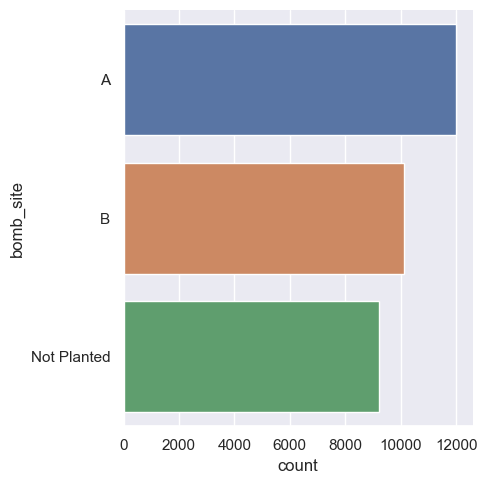

_________________________________________________________________________________

de_cbble
A              378
B              565
Not Planted    502
Name: bomb_site, dtype: int64

Planting in Bombsite B has a 19.83% better chance at winning than planting at Bombsite A.


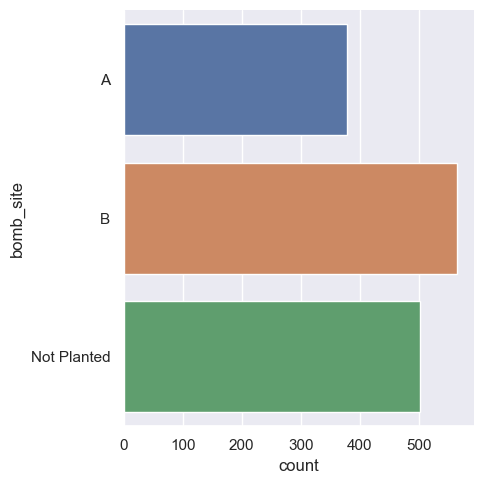

_________________________________________________________________________________

de_dust2
A              2235
B              1629
Not Planted    1606
Name: bomb_site, dtype: int64

Planting in Bombsite A has a 15.68% better chance at winning than planting at Bombsite B.


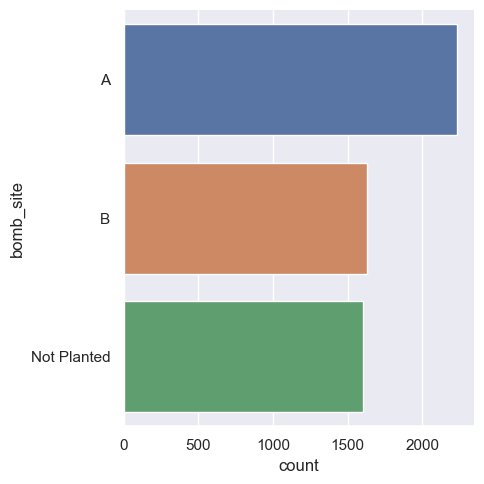

_________________________________________________________________________________

de_inferno
A              5334
B              5055
Not Planted    3117
Name: bomb_site, dtype: int64

Planting in Bombsite A has a 2.69% better chance at winning than planting at Bombsite B.


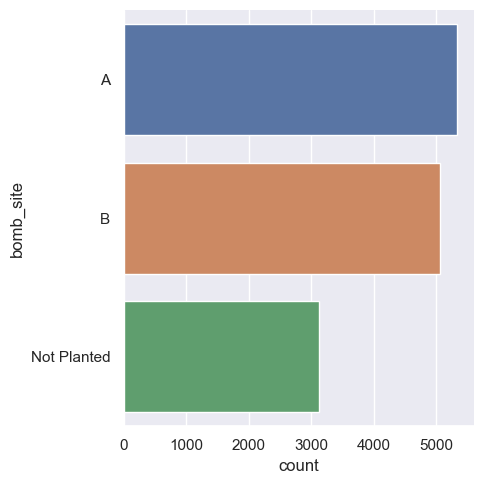

_________________________________________________________________________________

de_mirage
A              11417
B               8690
Not Planted     9990
Name: bomb_site, dtype: int64

Planting in Bombsite A has a 13.56% better chance at winning than planting at Bombsite B.


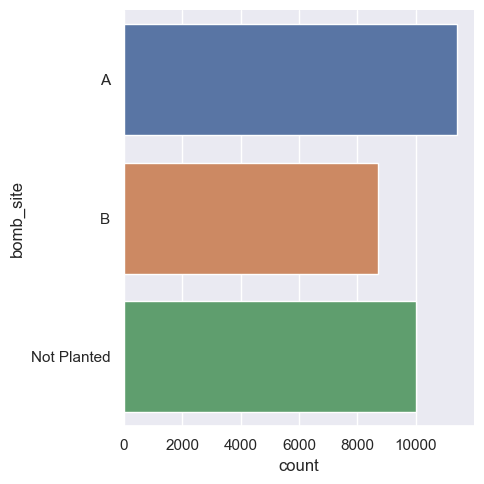

_________________________________________________________________________________

de_overpass
A              1898
B              2036
Not Planted    1621
Name: bomb_site, dtype: int64

Planting in Bombsite B has a 3.51% better chance at winning than planting at Bombsite A.


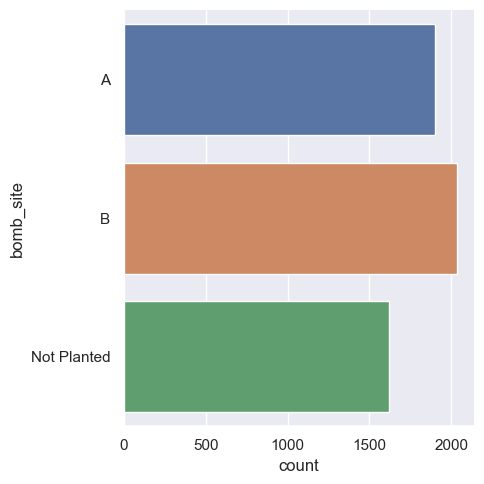

_________________________________________________________________________________

de_train
A              1049
B               798
Not Planted     908
Name: bomb_site, dtype: int64

Planting in Bombsite A has a 13.59% better chance at winning than planting at Bombsite B.


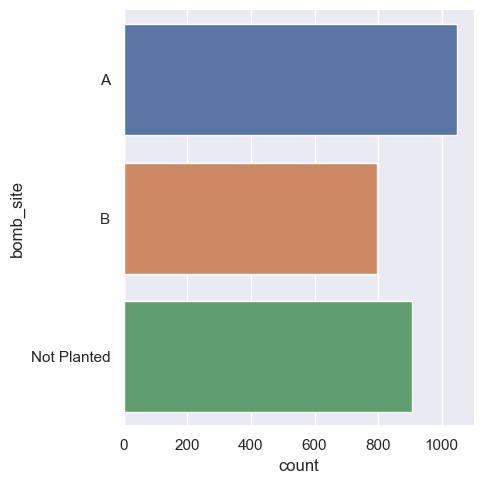

_________________________________________________________________________________



In [248]:
for map_name in df_round_end_sep_df.keys():
    print(map_name)
    df = df_round_end_sep_df[map_name]
    df = df[['is_bomb_planted','t_win','bomb_site','ct_win']]
    bomb_planted_t_win = df[df['t_win']].sort_values(axis=0,by='bomb_site')
    
    print(bomb_planted_t_win['bomb_site'].value_counts().sort_index())
    a_plant = bomb_planted_t_win['bomb_site'].value_counts().sort_index()[0]
    b_plant = bomb_planted_t_win['bomb_site'].value_counts().sort_index()[1]
    #print(a_plant,b_plant)
    diff = abs(a_plant-b_plant)/(a_plant+b_plant)*100
    
    print()
    if (a_plant>b_plant):
        print("Planting in Bombsite A has a {}% better chance at winning than planting at Bombsite B.".format(round(diff,2)))
    elif (a_plant<b_plant):
        print("Planting in Bombsite B has a {}% better chance at winning than planting at Bombsite A.".format(round(diff,2)))
    else:
        print("Both sides have equal chance at winning.")
  
    sb.catplot(y = "bomb_site", data = bomb_planted_t_win, kind = "count")
    plt.show()
    
    print("_________________________________________________________________________________")
    print()
 

### Scatter plot of death locations

Map: de_cache
Total Deaths:442320


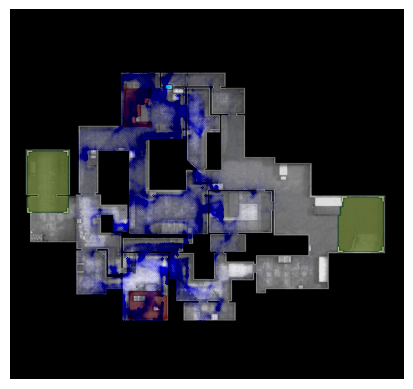

_____________________________________________________________________
Map: de_cbble
Total Deaths:21542


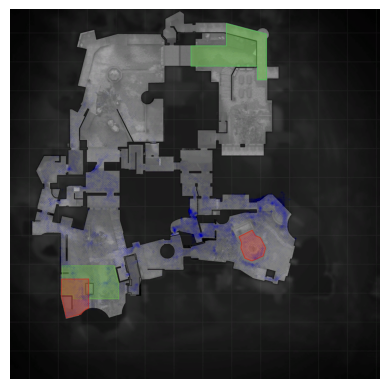

_____________________________________________________________________
Map: de_dust2
Total Deaths:72877


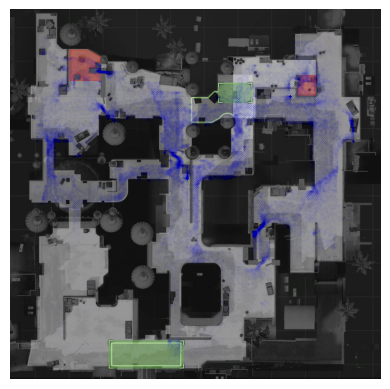

_____________________________________________________________________
Map: de_inferno
Total Deaths:192439


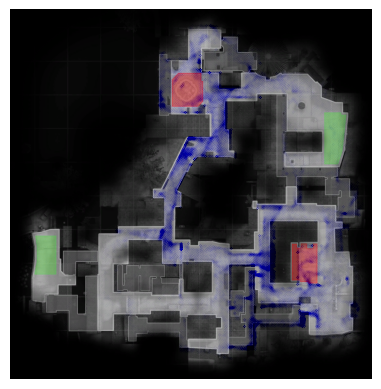

_____________________________________________________________________
Map: de_mirage
Total Deaths:444856


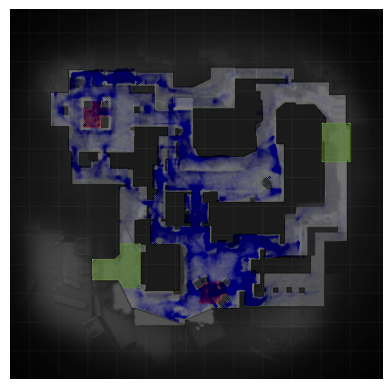

_____________________________________________________________________
Map: de_overpass
Total Deaths:86000


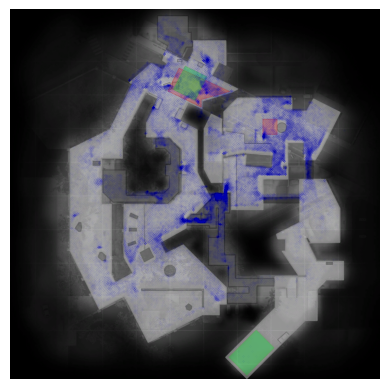

_____________________________________________________________________
Map: de_train
Total Deaths:44032


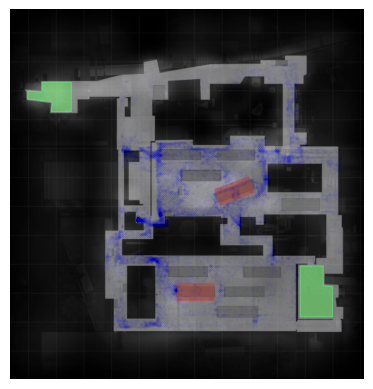

_____________________________________________________________________


In [249]:
for map_name in df_cleaned_sep_df.keys():
    print("Map:",map_name)
    endx = map_dict[map_name]['EndX']
    endy = map_dict[map_name]['EndY']
    resx = map_dict[map_name]['ResX']
    resy = map_dict[map_name]['ResY']
    startx = map_dict[map_name]['StartX']
    starty = map_dict[map_name]['StartY']
    df = df_cleaned_sep_df[map_name]
    total_deaths = len(df)
    print("Total Deaths:{}".format(total_deaths))
    if (total_deaths>100000):
        size=0.000005
    elif (total_deaths<10000):
        size=0.001
    else:
        size=0.0001
    
    
    im = plt.imread('maps/'+map_name+'.png')
    plt.axis([startx, endx, starty, endy])
    plt.scatter(x=df.vic_pos_x, y=df.vic_pos_y, s=size, zorder=1, c='blue')
    #plt.scatter(x=df.att_pos_x, y=df.att_pos_y, s=size, zorder=1, c='red')
    plt.imshow(im, zorder=0, extent=[startx, endx, starty, endy])
    plt.axis('off')
    plt.show()
    print("_____________________________________________________________________")

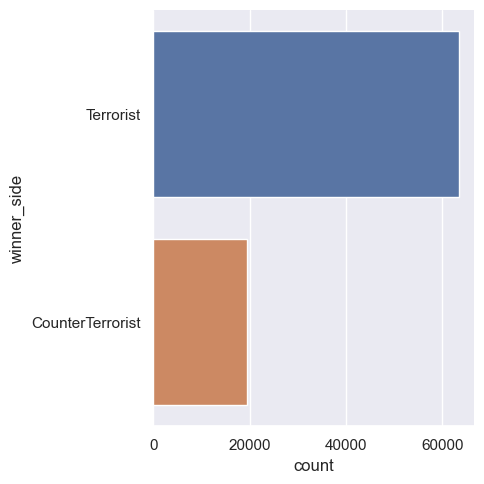

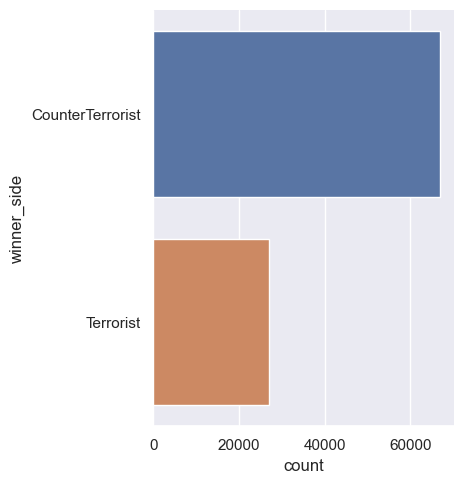

In [250]:
bomb_planted = round_end_stats_df[round_end_stats_df['is_bomb_planted'] == True]
bomb_not_planted = round_end_stats_df[round_end_stats_df['is_bomb_planted'] == False]
sb.catplot(y = "winner_side", data = bomb_planted, kind = "count")
sb.catplot(y = "winner_side", data = bomb_not_planted, kind = "count")
plt.show()

# Code testing area

In [251]:
round_end_stats_df['winner_team'].value_counts()

Team 1                  89860
Team 2                  86538
Team Kinguin               74
Izako Boars                57
PRiDE                      33
EURONICS Gaming            32
Sprout                     32
AGO Esports                32
Endpoint                   31
PACT                       27
--to be determined--       22
ALTERNATE aTTaX            14
fish123                     8
ONCA Gaming                 8
Name: winner_team, dtype: int64

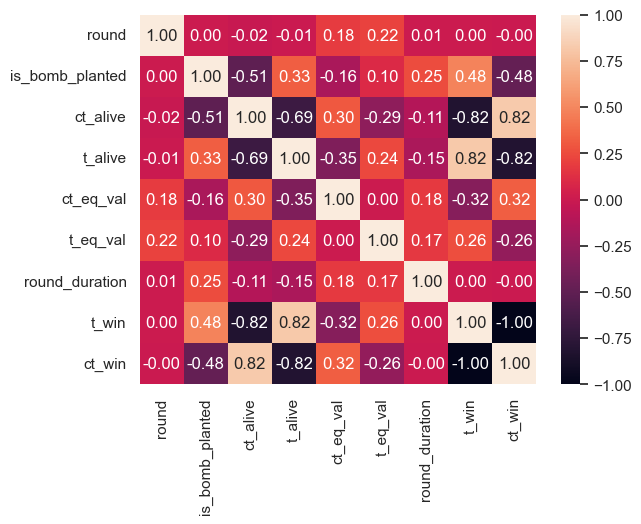

In [252]:
sb.heatmap(round_end_stats_df.corr(), vmin = -1, vmax = 1, annot = True, fmt=".2f")
plt.show()

In [253]:
demo_clean_df.sort_values(by=['round','file'])

,file,map,round,start_seconds,end_seconds,winner_team,winner_side,round_type,ct_eq_val,t_eq_val,round_duration,loser_side,t_win,ct_win
24,esea_match_13779704.dem,de_cache,1,131.2592,188.1189,Team 1,CounterTerrorist,PISTOL_ROUND,4550,3850,56.8597,Terrorist,False,True
63,esea_match_13779769.dem,de_inferno,1,131.5340,221.2626,Team 1,CounterTerrorist,PISTOL_ROUND,4400,4250,89.7286,Terrorist,False,True
112,esea_match_13779771.dem,de_inferno,1,131.7829,250.9257,Team 2,Terrorist,PISTOL_ROUND,3550,4350,119.1428,CounterTerrorist,True,False
139,esea_match_13779775.dem,de_inferno,1,131.8334,235.4224,Team 1,CounterTerrorist,PISTOL_ROUND,4250,4350,103.5890,Terrorist,False,True
169,esea_match_13779776.dem,de_overpass,1,131.3957,209.9951,Team 1,CounterTerrorist,PISTOL_ROUND,4100,3300,78.5994,Terrorist,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179656,esea_match_13790831.dem,de_cache,53,5260.9780,5384.8860,Team 1,Terrorist,NORMAL,32050,29900,123.9080,CounterTerrorist,True,False
106382,esea_match_13786284.dem,de_cache,54,5111.0860,5230.8210,Team 1,Terrorist,NORMAL,26650,28050,119.7350,CounterTerrorist,True,False
132086,esea_match_13787779.dem,de_cache,54,5209.3420,5301.2890,Team 1,Terrorist,NORMAL,35450,25150,91.9470,CounterTerrorist,True,False
137426,esea_match_13788110.dem,de_inferno,54,5653.4230,5789.8660,Team 1,Terrorist,NORMAL,29100,28300,136.4430,CounterTerrorist,True,False


de_cache
Terrorist           31335
CounterTerrorist    28665
Name: winner_side, dtype: int64


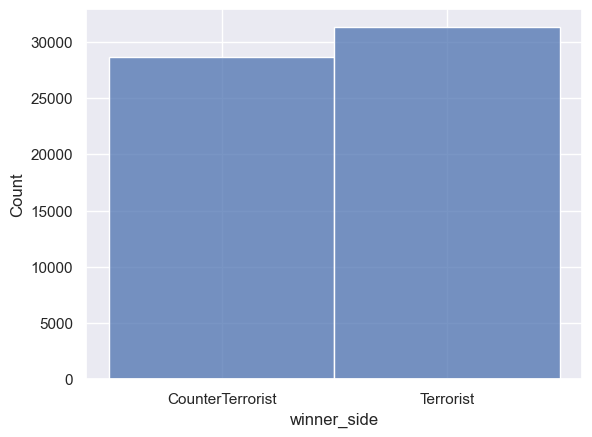


de_cbble
Terrorist           1445
CounterTerrorist    1362
Name: winner_side, dtype: int64


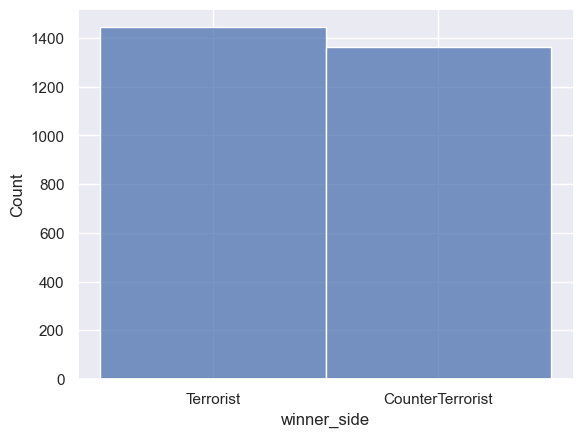


de_dust2
Terrorist           5470
CounterTerrorist    4462
Name: winner_side, dtype: int64


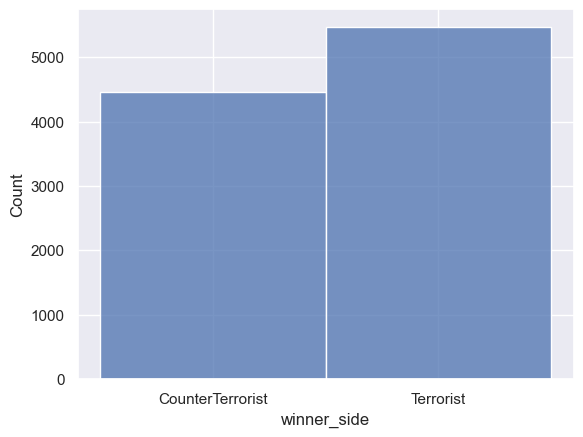


de_inferno
Terrorist           13506
CounterTerrorist    12204
Name: winner_side, dtype: int64


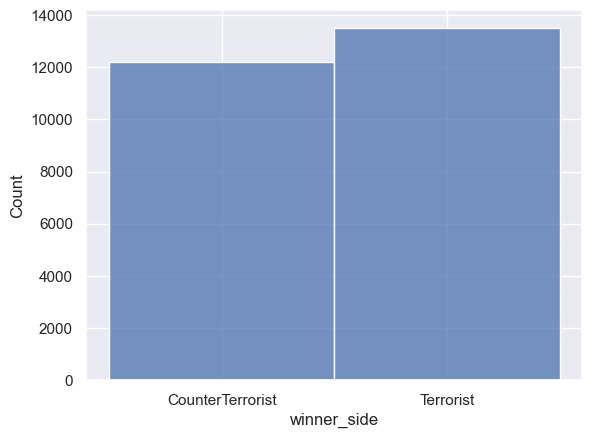


de_mirage
CounterTerrorist    30139
Terrorist           30097
Name: winner_side, dtype: int64


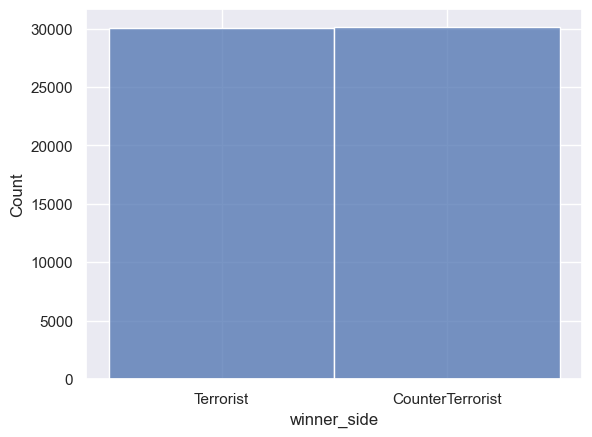


de_overpass
CounterTerrorist    5918
Terrorist           5555
Name: winner_side, dtype: int64


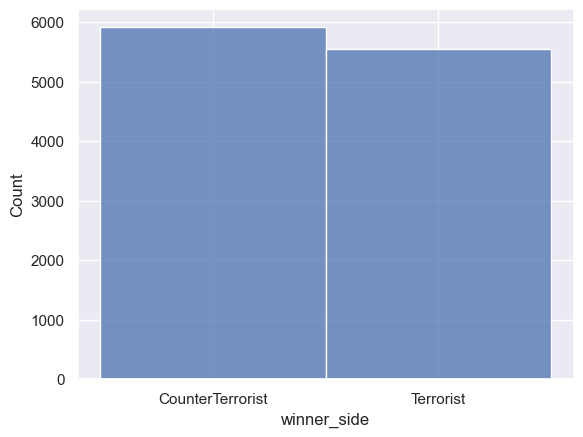


de_train
CounterTerrorist    3193
Terrorist           2755
Name: winner_side, dtype: int64


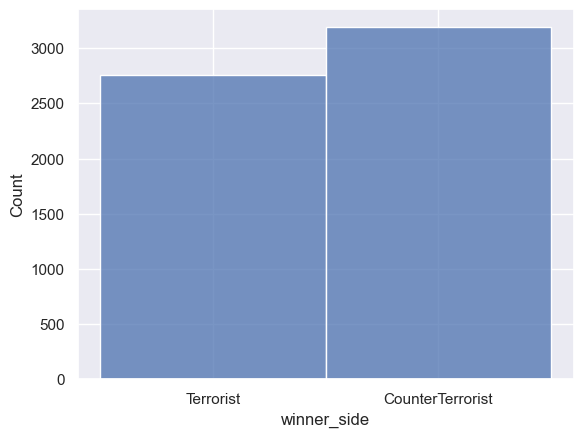

In [254]:
# which side is likely to win based on the map
for map_name in df_round_end_sep_df.keys():    
    print(map_name)
    df = df_round_end_sep_df[map_name]
    print(df['winner_side'].value_counts())
    sb.histplot(data=df['winner_side'], stat='count')
    #sb.boxplot(x='is_bomb_planted',y='winner_side',data=df)
    plt.show()
    print()